#Data Loading

In [ ]:
!pip install vit_keras -q 
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import sys
import random
import warnings
import numpy as np 
import pandas as pd
from time import time
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images

import tensorflow as tf
from vit_keras import  vit, utils 
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
    Dense, Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, 
    Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, 
    BatchNormalization, SeparableConv2D, Flatten )

from sklearn.metrics import classification_report
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MAIN_PATH = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.25,
                             zoom_range=0.1,
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range = [0.5, 1.5],
                             shear_range = 0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
def get_transforms(data):
    
    if data == 'train':
        IMG_TRAIN = MAIN_PATH +'train/'
        train_generator = datagen.flow_from_directory(
            directory = IMG_TRAIN,
            batch_size  = 16,
            shuffle=True,
            class_mode = 'categorical',
            target_size = (224, 224)
        )

        return train_generator

    elif data == 'valid':
        IMG_VAL = MAIN_PATH + 'val/'
        valid_generator = datagen.flow_from_directory(
            directory = IMG_VAL,
            batch_size = 16,
            shuffle = True,
            class_mode = 'categorical',
            target_size = (224, 224)
        )

        return valid_generator

    else :
        #IMG_TEST = MAIN_PATH + 'test/'
        #test_generator = test_datagen.flow_from_directory(
        #    directory = IMG_TEST,
        #    batch_size = 8,
        #    shuffle = False,
        #    class_mode = None,
        #    target_size = (224, 224)
        #)
        IMG_TEST = MAIN_PATH + 'test/'
        test_generator = test_datagen.flow_from_directory(
            directory = IMG_TEST,
            batch_size = 16,
            shuffle = False,
            class_mode = 'categorical',
            target_size = (224, 224)
        )

        return test_generator

In [ ]:
train = get_transforms('train')
valid = get_transforms('valid')
test = get_transforms('test')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Modeling

##Vanila VIT

In [ ]:
image_size = 224
model = vit.vit_b16(
    image_size = image_size,
    activation = 'softmax',
    pretrained = True,
    include_top = True,
    pretrained_top = False,
    classes = 2
)
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=1, validation_data=test, verbose=1)
for i, l in enumerate(model.layers):
  l.trainable = False

model.layers[-1].trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=10, validation_data=valid, verbose=1)

326/326 [==============================] - 144s 394ms/step - loss: 0.1958 - accuracy: 0.9199 - val_loss: 0.2857 - val_accuracy: 0.8734
Epoch 1/10
326/326 [==============================] - 133s 371ms/step - loss: 0.1408 - accuracy: 0.9415 - val_loss: 0.7833 - val_accuracy: 0.7500
Epoch 2/10
326/326 [==============================] - 117s 359ms/step - loss: 0.1068 - accuracy: 0.9597 - val_loss: 0.3419 - val_accuracy: 0.8750
Epoch 3/10
326/326 [==============================] - 117s 359ms/step - loss: 0.1052 - accuracy: 0.9611 - val_loss: 0.5299 - val_accuracy: 0.8750
Epoch 4/10
326/326 [==============================] - 117s 359ms/step - loss: 0.0948 - accuracy: 0.9678 - val_loss: 0.6133 - val_accuracy: 0.7500
Epoch 5/10
326/326 [==============================] - 118s 361ms/step - loss: 0.1021 - accuracy: 0.9615 - val_loss: 0.5694 - val_accuracy: 0.8125
Epoch 6/10
326/326 [==============================] - 118s 362ms/step - loss: 0.0995 - accuracy: 0.9617 - val_loss: 0.7038 - val_accura

In [ ]:
y_pred = model.predict(test, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)
def create_df (dataset, label):
    filenames = []  
    labels = []
    for file in os.listdir(MAIN_PATH + f'{dataset}/{label}'):
        filenames.append(file)
        labels.append(label)
    return pd.DataFrame({'filename':filenames, 'label':labels})

test_NORMAL = create_df('test', 'NORMAL')
test_PNEUMONIA = create_df('test', 'PNEUMONIA')
test_ori = test_NORMAL.append(test_PNEUMONIA, ignore_index=True)
test_ori['label'] = test_ori['label'].apply(lambda x: 0 if x=='NORMAL' else 1)
y_true = test_ori['label'].values
print(classification_report(y_true, y_pred))

39/39 [==============================] - 6s 157ms/step
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       234
           1       0.96      0.87      0.91       390

    accuracy                           0.90       624
   macro avg       0.89      0.91      0.89       624
weighted avg       0.91      0.90      0.90       624



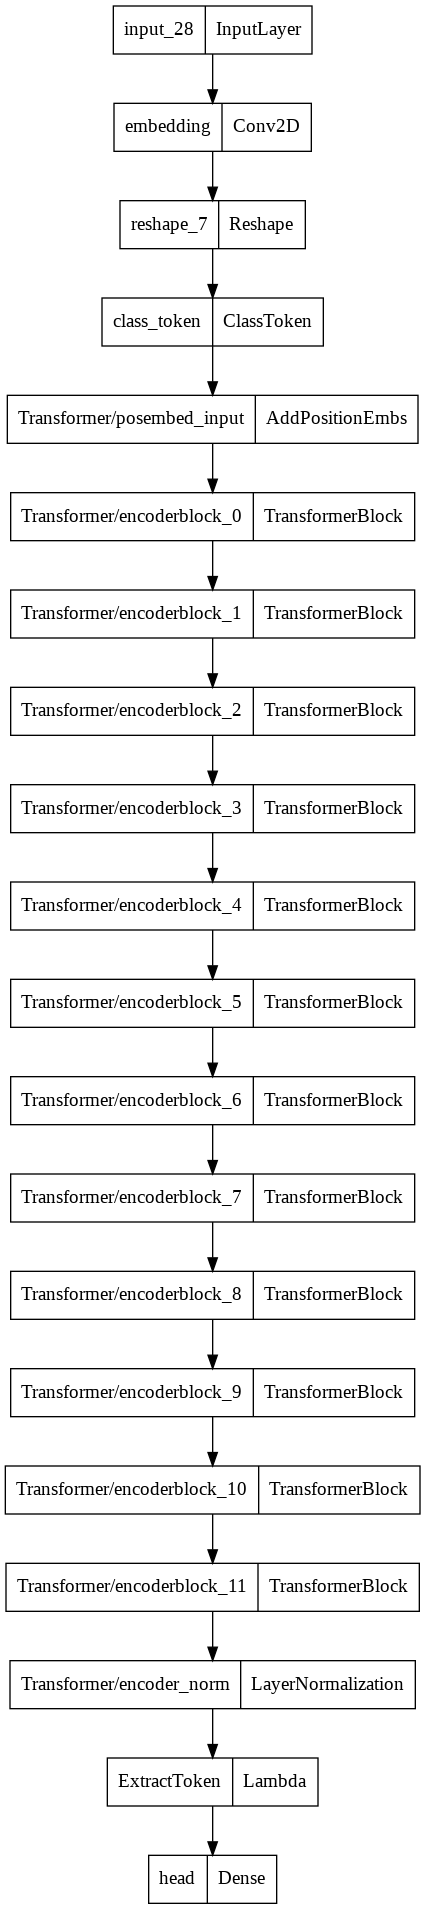

In [ ]:
tf.keras.utils.plot_model(model)

#Custom VIT

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.25, patience=5, verbose=1, mode='max',
    min_delta=1e-10, cooldown=0, min_lr=0
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='max',
    baseline=None, restore_best_weights=True
)

ckpt = ModelCheckpoint(
    filepath = './saved_model/checkpoint/',
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True
)

callbacks = [reduce_learning_rate, early_stopping, ckpt]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Lambda, Concatenate, concatenate, Input, Dropout
model = vit.vit_b16(
    image_size = image_size,
    activation = 'softmax',
    pretrained = True,
    include_top = True,
    pretrained_top = False,
    classes = 2
)

cnn_block = Sequential()
cnn_block.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(224,224,3)))
cnn_block.add(Conv2D(256, kernel_size=5, activation='relu'))
cnn_block.add(Conv2D(768, kernel_size=5, activation='relu'))
cnn_block.add(MaxPooling2D(pool_size=214,padding="valid"))
cnn_block.add(Lambda(lambda x:x[::,0,:]))

input = Input(shape=(224, 224, 3))
cnn_output = cnn_block(input)

y = model.layers[1](input)
for j in range(2,5):
  y = model.layers[j](y)

y,_ = model.layers[5](y)

y = concatenate([y,cnn_output], axis=1)

for i in range(6,17):
  y,_ = model.layers[i](y)
  y = concatenate([y, cnn_output], axis=1)

for k in range(17,19):
  y = model.layers[k](y)

y = Dropout(0.1)(y)
y = model.layers[-1](y)

new_model = Model(inputs=input, outputs=y)

def weighted_bincrossentropy(true, pred, weight_zero = 1.9448173, weight_one = 0.67303226):
    bin_crossentropy = K.binary_crossentropy(true, pred)
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 
    return K.mean(weighted_bin_crossentropy)
new_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss=weighted_bincrossentropy, metrics=['accuracy'])

from sklearn.utils import class_weight
train_NORMAL = create_df('tra in', 'NORMAL')
train_PNEUMONIA = create_df('train', 'PNEUMONIA')
train_ori = train_NORMAL.append(train_PNEUMONIA, ignore_index=True)
train_ori['label'] = train_ori['label'].apply(lambda x: 0 if x=='NORMAL' else 1)
y_train = train_ori['label'].values
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)

history = new_model.fit(train, epochs=3, validation_data=test, callbacks=callbacks, verbose=1)

/usr/local/lib/python3.8/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/3
326/326 [==============================] - 156s 423ms/step - loss: 0.2468 - accuracy: 0.9124 - val_loss: 0.3167 - val_accuracy: 0.8910 - lr: 1.0000e-04
Epoch 2/3
326/326 [==============================] - 134s 411ms/step - loss: 0.1473 - accuracy: 0.9475 - val_loss: 0.4157 - val_accuracy: 0.9038 - lr: 1.0000e-04
Epoch 3/3
326/326 [==============================] - 134s 410ms/step - loss: 0.1321 - accuracy: 0.9559 - val_loss: 0.2893 - val_accuracy: 0.9167 - lr: 1.0000e-04


In [ ]:
for i, l in enumerate(new_model.layers):
  l.trainable = False

new_model.layers[6].trainable = True
new_model.layers[32].trainable = True
new_model.compile(optimizer=Adam(learning_rate=1e-6, decay=1e-6), loss=weighted_bincrossentropy, metrics=['accuracy'])
history = new_model.fit(train, epochs=10, validation_data=test, callbacks=callbacks, verbose=1)

Epoch 1/10
326/326 [==============================] - 149s 412ms/step - loss: 0.0791 - accuracy: 0.9749 - val_loss: 0.2863 - val_accuracy: 0.9167 - lr: 1.0000e-06
Epoch 2/10
326/326 [==============================] - 131s 401ms/step - loss: 0.0785 - accuracy: 0.9753 - val_loss: 0.2847 - val_accuracy: 0.9167 - lr: 1.0000e-06
Epoch 3/10
326/326 [==============================] - 131s 400ms/step - loss: 0.0787 - accuracy: 0.9785 - val_loss: 0.2829 - val_accuracy: 0.9167 - lr: 1.0000e-06
Epoch 4/10
326/326 [==============================] - 130s 399ms/step - loss: 0.0768 - accuracy: 0.9766 - val_loss: 0.2820 - val_accuracy: 0.9167 - lr: 1.0000e-06
Epoch 5/10
326/326 [==============================] - 130s 398ms/step - loss: 0.0841 - accuracy: 0.9734 - val_loss: 0.2795 - val_accuracy: 0.9167 - lr: 1.0000e-06
Epoch 6/10
326/326 [==============================] - 130s 399ms/step - loss: 0.0803 - accuracy: 0.9720 - val_loss: 0.2781 - val_accuracy: 0.9183 - lr: 1.0000e-06
Epoch 7/10
326/326 [==

In [ ]:
y_pred = new_model.predict(test, verbose=1)
y_pred = np.argmax(y_pred, axis = 1)
test_NORMAL = create_df('test', 'NORMAL')
test_PNEUMONIA = create_df('test', 'PNEUMONIA')
test_ori = test_NORMAL.append(test_PNEUMONIA, ignore_index=True)
test_ori['label'] = test_ori['label'].apply(lambda x: 0 if x=='NORMAL' else 1)
y_true = test_ori['label'].values
print(classification_report(y_true, y_pred))

39/39 [==============================] - 10s 166ms/step
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



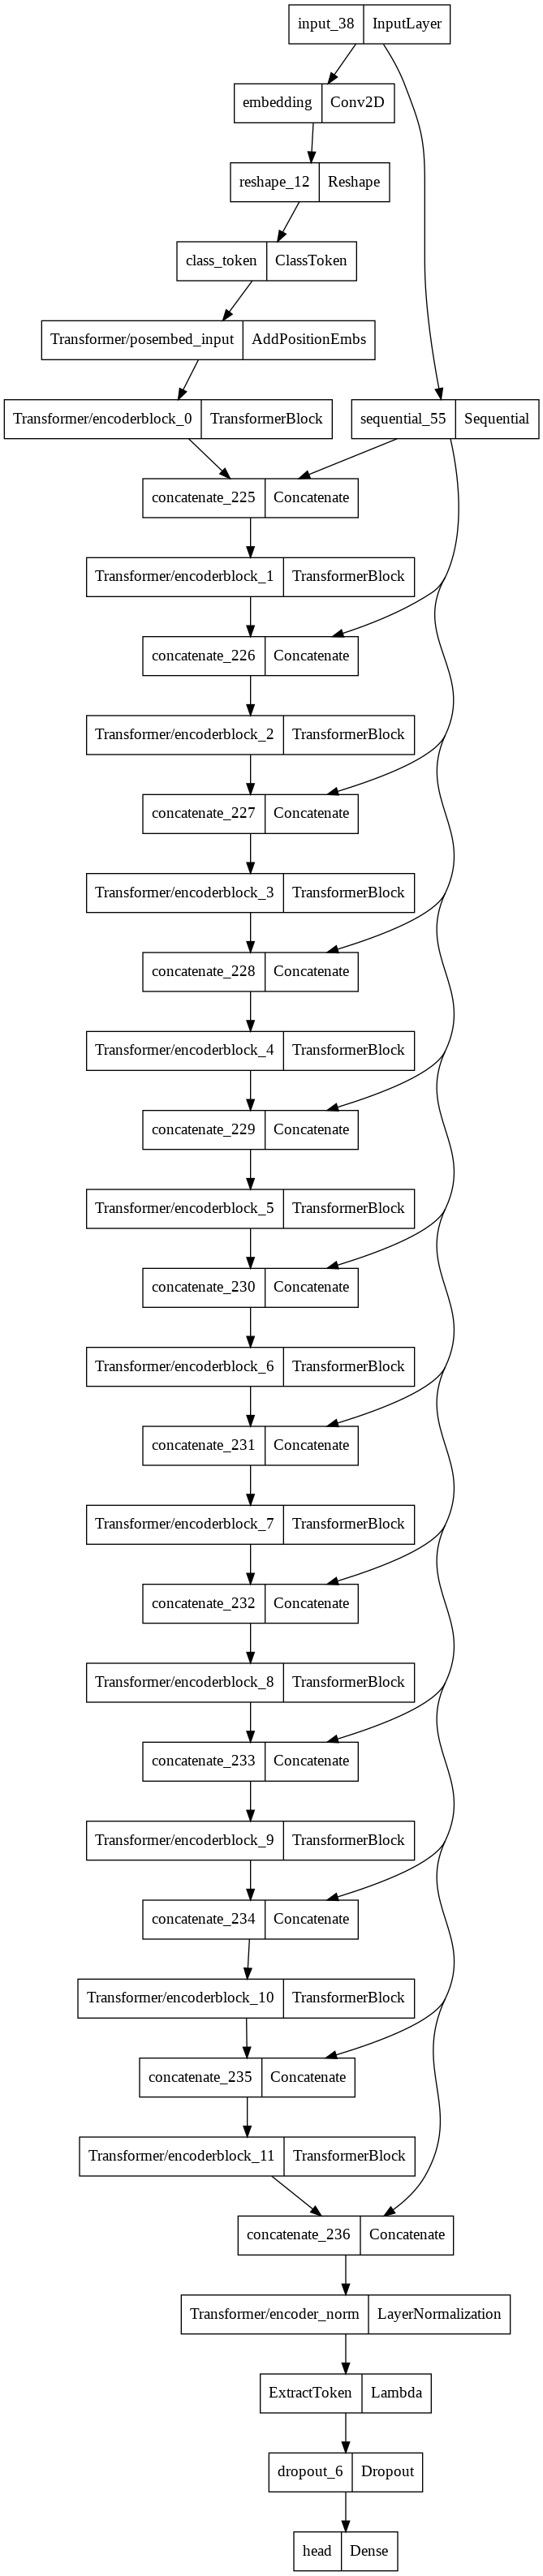

In [ ]:
tf.keras.utils.plot_model(new_model)